# Classification des chiffres manuscrits MNIST

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
#from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
import os
import time
# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

## Charger des données MNIST à partir de Torchvision
Torchvision permet de charger les données du MNIST de manière pratique. Nous utiliserons un batch_size de 64 pour la formation et de 64 pour les tests sur cette base de données. Les valeurs 0,1307 et 0,3081 utilisées pour la transformation Normalize() ci-dessous sont la moyenne globale et l'écart-type de la base de données MNIST. **transforme.ToTensor()** convertit l'ensemble du tableau en tenseur de torche et le divise par 255.  Les valeurs sont donc comprises entre 0,0 et 1,0.

In [2]:
# On defini la transformation qui normalise les données
transform = transforms.Compose([ transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                               ])

In [3]:
# On télécharge et charge les données 
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Dans PyTorch, **DataLoader** contient quelques options interessantes autres que dataset et batch size. par exemple l'utilisation de $num workers >1$ pour utiliser les sous processus pour charger les données de manière asynchrone ou utiliser la RAM (via **pin_memory**) pour accelérer les transfert de RAM vers le GPU

In [4]:
len(test_set),len(train_set)


(10000, 60000)

## Preproccessing des données
Transformons notre objet trainloader en un itérateur avec iter afin que nous puissions accéder à nos images et à nos étiquettes à partir de ce générateur. Nous pouvons voir la forme comme $64\times 1\times 28\times 28$. cela signifi que:

- 64: Represents 64 images
- 1 : un cannal donc la couleur ==>> Grayscale(grise)
- $28$ par 28 pixel: la forme des images


In [5]:
examples = enumerate(trainLoader)
batch_idx, (images, labels) = next(examples)
print("le type de données: ",type(images)) # Checking the datatype 
print("la tailles des images :", images.shape) # the size of the image
print("la taille des labels :", labels.shape) # the size of the labels

le type de données:  <class 'torch.Tensor'>
la tailles des images : torch.Size([64, 1, 28, 28])
la taille des labels : torch.Size([64])


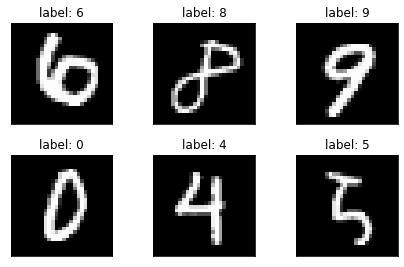

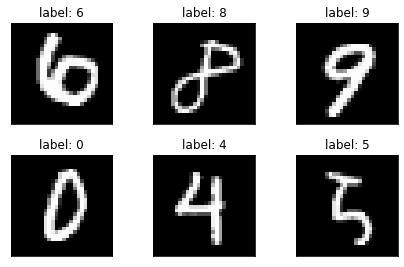

In [6]:

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray')
    plt.title("label: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])
fig

## construction du réseau
 

Nous allons constuire notre réseau en utilisant la méthode **nn.module** dans la classe des objets orientées. Ce réseau sera composé de 2 couches de convolutions 2D suivies de des couches FC. Comme fonctions d'activations on utilisera la ReLU et comme moyen de regularisation  on utilisera le Dropout

La fonction **Forward()** définie la façon dont on calcule la sortie en utilisant les couches, elle permet de propager les calculs vers l'avant dans le résau

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Instancier(créer) les 2 couches de convolution
        # On peut calculer la taille de sortie de chaque de convolution comme:
        # outpout = [(in_channel + 2*padding - kernel_size) / stride] + 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
        
        # Instancier la ReLU non lineaire
        self.relu = nn.ReLU(inplace=True)
        # après la première couche de convolution la sortie est
        # [(28 + 2*1 - 3)/1] + 1 = 28. car image.shape=(N,1,28,28)
        
        # Instancier une couche de max pooling 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Lorqu'on applique le premier max pooling avec kernel=2, on a divisé par 2 
        # donc on obtient 28 / 2 = 14
        # l'application du second max pooling donnne 14/2=7
        
        # Instancier les couches de fully connected 
        self.fc1 = nn.Linear(24 * 7*7, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Appliquer la conv suivie de la  relu, puis la ligne suivante prendre la pool de tout
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Appliquer la conv suivie de la  relu, puis la ligne suivante prendre la pool de tout
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # aplatit la sortie de la couche de convolution en un vecteur
        x = x.view(x.size(0),-1)
        #print("+++",x.size(0))
        
        # Appliquer la première couche de Fully connected
        x = self.relu(self.fc1(x))
        
        # Appliquer la deuxième couche de Fully connected et retourner le resultat
        return self.fc2(x)

Définissons les optimiseurs que nous utiliserons.
Ensuite, nous utiliserons l'optimiseur Stochastic Gradient Descent pour la mise à jour des hyperparamètres. model.parameters() fournira les paramètres pouvant être appris à l'optimiseur et lr=0.01 définit les pas d'apprentissage pour les mises à jour des paramètres.


In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
model.to(device)


Net(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

Après la passe en avant, la loss function est calculée à partir des **etiquettes** et **les prédictions**  afin de mettre à jour les poids. La mise en place de la fonction de perte est une étape assez simple. On utilise ici la perte d'entropie croisée, qui mesure la performance d'un modèle de classification dont la sortie est une probabilité comprise entre 0 et 1. Il convient de noter que la perte d'entropie croisée augmente lorsque la probabilité prévue diverge de l'étiquette réelle.



## Apprentissage et test du modèle
Le chargement des données est géré par Dataloader, ensuite on commence à mettre à zero le gradient en utilisant **optimizer.zero_grad()** puisque Pytorch par defaut cummule le gradient
le **backward()** permet de collecter le nouveau  gradient qu'on propagera dans les paramètres du réseau via à **optimizer.step()**

Notre modèle est maintenant prêt à être entrainé. On commençe par établir une taille d'époque. Une époque c'est, lorsqu'on traverse toute la base de données une seule fois pendant l'apprentissage. 

In [9]:
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []
def Training(epochs):
    for epoch in range(epochs):
        # initialisation
        total_train_loss = 0
        total_val_loss = 0
        model.train()
        total = 0
        taille=0
        
        # entrainement du model
        for idx, (image, label) in enumerate(trainLoader):
            taille+=image.shape[0]
            # mettre à zero le gradient
            optimizer.zero_grad()
            # le calcul de forward
            pred = model(image)
            # calcul de la loss function
            loss = criterion(pred, label)
            total_train_loss += loss.item()
            # calcul du gradient
            loss.backward()
            # mise à jour des poids
            optimizer.step()
            # prédiction 
            pred = F.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]: # verifier si label==prediction
                    total = total + 1 
        # calcul de l'accuracy du batch
        accuracy_train = total / len(train_set)
        accuracy_total_train.append(accuracy_train)
        # calcul de l'accuracy du batch
        total_train_loss = total_train_loss / (idx + 1)
        train_loss.append(total_train_loss)

        # validation du model
        model.eval()
        total = 0
        for idx, (image, label) in enumerate(testLoader):
            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            pred = F.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy_val = total / len(test_set)
        accuracy_total_val.append(accuracy_val)

        total_val_loss = total_val_loss / (idx + 1)
        val_loss.append(total_val_loss)

        if epoch % 1 == 0:
            print("Epoch:{}/{}".format(epoch, epochs),
                "Train_loss: {:.4f}".format(total_train_loss),
                "Test_loss: {:.4f}".format(total_val_loss),
                "Train_accuracy: {:.4f}".format(accuracy_train),
                "Test_accuracy: {:.4f}".format(accuracy_val)
                 )

In [10]:
%%time
training=Training(6)

Epoch:0/6 Train_loss: 0.1475 Test_loss: 0.0808 Train_accuracy: 0.9541 Test_accuracy: 0.9759
Epoch:1/6 Train_loss: 0.0720 Test_loss: 0.0655 Train_accuracy: 0.9785 Test_accuracy: 0.9803
Epoch:2/6 Train_loss: 0.0632 Test_loss: 0.0749 Train_accuracy: 0.9810 Test_accuracy: 0.9792
Epoch:3/6 Train_loss: 0.0588 Test_loss: 0.0669 Train_accuracy: 0.9831 Test_accuracy: 0.9783
Epoch:4/6 Train_loss: 0.0603 Test_loss: 0.0526 Train_accuracy: 0.9823 Test_accuracy: 0.9839
Epoch:5/6 Train_loss: 0.0539 Test_loss: 0.0583 Train_accuracy: 0.9848 Test_accuracy: 0.9835
CPU times: user 11min 49s, sys: 36.8 s, total: 12min 26s
Wall time: 6min 25s


In [11]:
def PlotLosses(train_loss, test_loss):
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Losses')
    plt.legend()
    plt.grid()

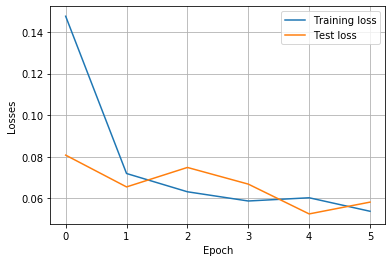

In [12]:
PlotLosses(train_loss,val_loss)

In [13]:
def PlotAccuracy(train_accuracy, test_accuracy):
    plt.plot(train_accuracy, label='Training accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

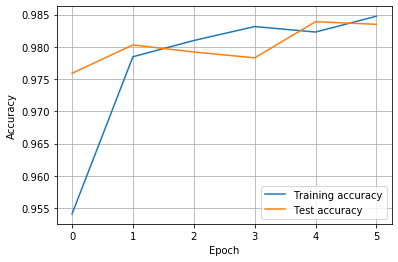

In [14]:
PlotAccuracy(accuracy_total_train,accuracy_total_val)

## Evaluation du modele
Maintenant que notre modèle est entraîné, nous pouvons simplement utiliser les poids pré-entraînés pour faire de nouvelles prédictions en désactivant les gradients. Ce que notre modèle nous renvoie, ce sont des logits.


In [21]:
examples = enumerate(testLoader)
idx, (Imag, labels) = next(examples)
idx,Imag.shape

(0, torch.Size([64, 1, 28, 28]))

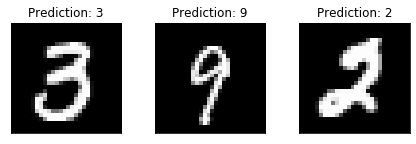

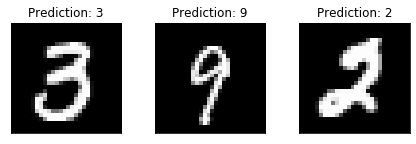

In [22]:

# on desactive les gradients
with torch.no_grad():
    logit = model(Imag)

fig = plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.imshow(Imag[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(logit.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [23]:
PATH = './mnist.pth'
torch.save(model.state_dict(), PATH)

In [20]:
classes=['0','1','2','3','4','5','6','7','8','9']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

moyenne=[]
for i in range(10):
    res=100 * class_correct[i] / class_total[i]
    moyenne.append(res)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('Test Accuracy =',np.mean(moyenne))

Accuracy of     0 : 100 %
Accuracy of     1 : 98 %
Accuracy of     2 : 100 %
Accuracy of     3 : 96 %
Accuracy of     4 : 98 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 95 %
Test Accuracy = 98.08110812521511
